# Bayesian model evaluation

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

/media/DATA/anaconda/envs/pystran/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Case study: respirometric model

The following respirometric model  for aerobic degradation of acetate without biomass storage will be used (Gernaey, 2002). It predicts the model output variable exogenous oxygen uptake rate of bacteria: $OUR_{ex}$ ($mg L^{-1} d^{-1}$).

$$\frac{dS}{dt} = -(1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1}{Y}\frac{S}{K_S + S}X$$
$$\frac{dX}{dt} = (1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1}{Y}\frac{S}{K_S + S}X-bX$$
$$OUR_{ex} = (1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1-Y}{Y}\frac{S}{S+k_S}X$$

with 

$S$: substrate concentration ($mgCOD\; L^{-1}$ ), <br>
$X$: biomass concentration ($mg COD\; L^{-1}$),<br>
$\tau$: retardation on biomass activity ($d^{-1}$ ), <br>
$Y$: yield of the biomass (-),<br>
$\mu_{max}$: maximum growth rate ($d^{-1}$), <br>
$K_s$: half-saturation Monod constant ($mg COD\; L^{-1}$) <br>
$\quad$(if $\mu$ equals half of $\mu_{max}$, the substrate $S$ equals $K_s$).

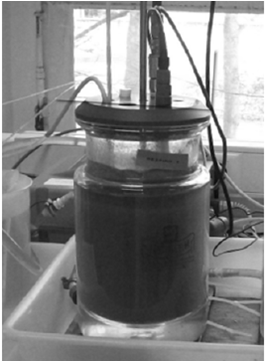

In [3]:
from IPython.display import Image
Image(filename='batcheactor.png', width=300)

<i><b>Caption:</b> How the reactor with sludge and bacteria looks like. We add small pulse of substrate (Acetate) to the reactor, the bacteria consume substrate and use oxygen, we measure Dissolved Oxygen and (indirectly) OUR</i>

Reference: 

<small>Gernaey, K., Petersen, B., Nopens, I., Comeau Y. and P.A. Vanrolleghem, Modeling aerobic carbon source degradation processes using titrimetric data and combined respirometric-titrimetric data: experimental data and model structure, Biotechnology and bioengineering, 79(7), 741-753, 2002</small>

To implement this model, we bring the differential equations into code. Based on two definitions, we will be able to run the model with different parameter sets.

In [4]:
#The model consist of differential equations, which needs integration (solver-based)
from scipy.integrate import odeint

def deriv_works(u, t, parameters, constants): #Derivative used in the general model function
    '''
    Differential equations of the respirometric model in code
    '''
    #Define the parameters
    mumax = np.float64(parameters[0])
    Y = np.float64(parameters[1])
    Ks = np.float64(parameters[2])
    tau = np.float64(parameters[3])
    
    b = np.float64(constants[0])
    kla = np.float64(constants[1])
    SOeq = np.float64(constants[2])
    
    monod = mumax*(u[1])/(u[1]+Ks)    #Monod Kinetic
    expo = 1.0 - np.exp(-t/tau)   

    #The model equations
    dXdt = (expo*monod - b)*u[0]                    #Biomassa
    dSsdt = -(1.0/Y)*expo*monod*u[0]              #Substraat
    dOdt = kla*(SOeq-u[2])-((1-Y)/Y)*expo*monod*u[0]   #Oxygen

    return np.array([dXdt, dSsdt, dOdt])

def respirometer_model(parameters, initial_cond, time):
    '''
    Run the respirometric model
    '''
    #Define the constants - experiment specific
    b = 0.62
    kla = 369.7334962
    SOeq = 8.4
    constant_values = np.array([b, kla, SOeq])

    #Define the initial conditions (Constants)Ss0
    Ss0 = 58.4899
    #Define the initial conditions (Uncertain) -> X0
    X0 = initial_cond[0]
    yinit = np.array([X0, Ss0, SOeq])  

    #Define the necessary parameters
    mumax = np.float64(parameters[0])
    Y = np.float64(parameters[1])
    Ks = np.float64(parameters[2])
    tau = np.float64(parameters[3])

    #Solve with LSODA scheme
    y, infodic = odeint(deriv_works, yinit, time, full_output=True, 
                         printmessg=False, args=(parameters, constant_values))

    #Get outputs
    X = y[:, 0]
    Ss = y[:, 1]
    O = y[:, 2]

    OUR_ex=((1 - np.exp(-time/tau))*mumax*(1-Y)/Y*Ss/(Ss+Ks)*X)/(24*60)
    return [time, X, Ss, O, OUR_ex, infodic]

In [5]:
#SET TIME
modeltime = np.arange(0.,0.05,0.0005)
#Since everything is in day, this reprecents more or less 1 hour and 12 minutes of time.

#set X0 as initial condition
X0 = 6.75632395e+02
#set the parameter values
mumax=4.
Y=0.78
Ks=0.4
tau=2.25e-04
parameters = [mumax, Y, Ks, tau]
uncertain_initial_condition = np.array([X0])
modeloutput = respirometer_model(parameters, uncertain_initial_condition, 
                                 modeltime)
#check if the integration succesful:
print modeloutput[-1]['message']

Integration successful.


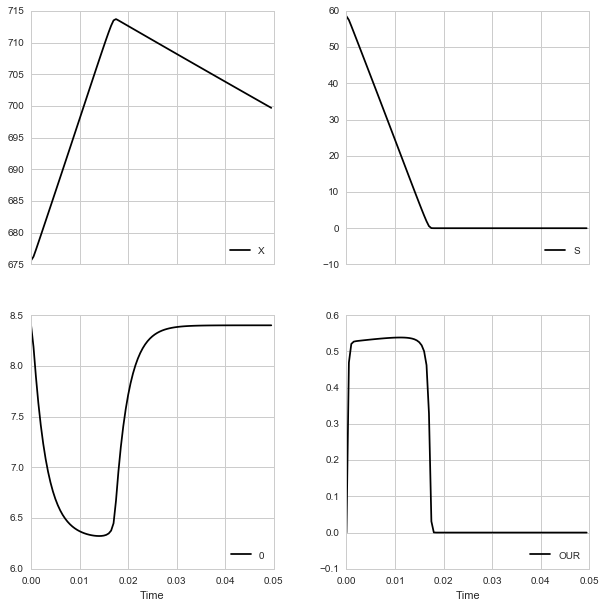

In [6]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace = 0.3)

ax1 = fig.add_subplot(221)
ax1.plot(modeloutput[0], modeloutput[1],'k',label = 'X')
ax1.set_xticklabels([])
ax1.legend(loc=4)

ax2 = fig.add_subplot(222)
ax2.plot(modeloutput[0], modeloutput[2],'k',label = 'S')
ax2.set_xticklabels([])
ax2.legend(loc=4)

ax3 = fig.add_subplot(223)
ax3.plot(modeloutput[0], modeloutput[3],'k',label = '0')
ax3.legend(loc=4)
ax3.set_xlabel('Time')

ax4 = fig.add_subplot(224)
ax4.plot(modeloutput[0], modeloutput[4],'k',label = 'OUR')
ax4.legend(loc=4)
ax4.set_xlabel('Time')

## Observations

The parameters in the model ($\tau, Y, K_s$ and $\mu_{max}$) are unknown and we want to charactize them using a known data set. 

(Moreover, since we can not easily measure the initial biomass when starting the experiment, we also consider the initial biomass $X_O$ as an uncertain/unknown input of our model.)

In [7]:
observations = pd.read_csv("respirometer_data.txt", sep="\t", index_col=0, 
                           names=["DO", "OURex"], skiprows=2)

In [8]:
observations.head()

,DO,OURex
0.000000,8.488234,0.006513
0.014845,8.488691,0.022208
0.031512,8.493058,0.037903
0.050000,8.495394,0.053598
0.066928,8.492392,0.069293


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8f3cce910>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fd8f00f9d50>], dtype=object)

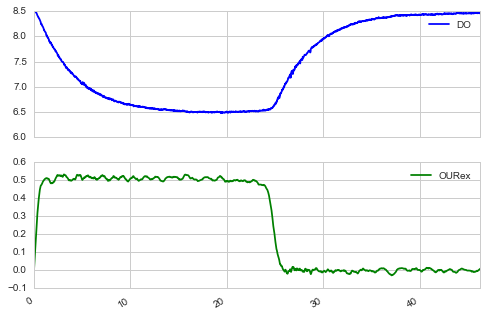

In [9]:
observations.plot(subplots=True)

## Emcee hammer

Emcee hammer is a Python Package for Bayesian statistics and provides a MIT licensed pure-Python implementation of [Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](http://msp.org/camcos/2010/5-1/p04.xhtml) wth more information on the implementation [here](http://arxiv.org/abs/1202.3665). The implementation provides parallelism of the ensemble method, emcee permits any user to take advantage of multiple CPU cores without extra effort.

In [10]:
from IPython.display import IFrame
IFrame('http://dan.iel.fm/emcee/current/', 800, 300)

### Applying emcee Hammer

The prior distribution:

* X0: 650.  -->  700.
* mumax: 3.5 -->  4.5
* Y: 0.77--> 0.81
* Ks: 0.3 -->  0.5
* tau: 0.00001  -->  0.001

First test, we want to estimate $\mu_{max}$ and K$_s$, $Y$ and $\tau$ based on the data-set:

In [11]:
def run_respiro(parameters):
    """
    """
    modeltime = np.arange(0.,0.05,0.0005)
    X0 = 6.75632395e+02

    mumax, Y, Ks, tau = parameters
    modeloutput = respirometer_model(parameters, uncertain_initial_condition, 
                                     modeltime)    
    return modeloutput

In [12]:
def get_modelerror(parameters, observed):
    """
    """
    # Run model
    
    # Get timesteps of model
    
    # 

In [13]:
def lnprior(parameters):
    mumax, Y, Ks, tau = parameters
    if 3.5 < mumax < 4.5 and 0.77 < Y < 0.81 and 0.3 < Ks < 0.5:
        return 0.0
    return -np.inf

Likelihood function (probability distribution over datasets so, conditioned on model parameters):

In [14]:
# gaussian, geen meeetfout,...
def lnlike(parameters, observed):
    mumax, Y, Ks, tau = parameters
    model = run_respiro()
    N = len(observed)
    sigma2 = np.std(observed)**2.
    loglike = -N/2. - N*np.log(sigma2)/2. - ((model-observed)**2).sum()
    return loglike

Full log-likelihood:

In [15]:
def lnprob(parameters, observed):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(parameters, observed)

In [16]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

NameError: name 'result' is not defined

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(res))

In [ ]:
sampler.run_mcmc(pos, 500)

## Comparison Frequentisic - Bayesian

Testing corner package, https://github.com/dfm/corner.py

In [ ]:
import numpy as np
import corner

ndim, nsamples = 5, 10000
samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
figure = corner.corner(samples)


In [ ]:
samples